<a href="https://colab.research.google.com/github/ram130849/Deep_Learning_Systems_Assignments/blob/main/TensorFlow/Ramki/E533_DLS_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model
import matplotlib.pyplot as plt
import librosa
import os
from tensorflow.keras.layers import BatchNormalization
import seaborn as sns
from sklearn.metrics import confusion_matrix
import gzip
import time
import pickle
from sklearn.preprocessing import OneHotEncoder
import random
from IPython import display
from scipy.stats import wasserstein_distance

P1: RNNs as a generative model

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = (x_train.astype("float32")) / 255.0
x_test = (x_test.astype("float32")) / 255.0

In [ ]:
print("X_train shape:",x_train.shape)
print("X_test shape:",x_test.shape)

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


In [ ]:
def extract_patches(x):
    x = tf.expand_dims(x, 0)
    x = tf.expand_dims(x, -1)
    x = tf.image.extract_patches(images=x,
                            sizes=[1, 7, 7, 1],
                            strides=[1, 7, 7, 1],
                            rates=[1, 1, 1, 1],
                            padding='VALID')
    
    x = tf.reshape(x,shape = (16,7,7,1))
    return x.numpy().reshape(16,49)

In [ ]:
x_tr = []
for i in range(x_train.shape[0]):
    x_tr.append(extract_patches(x_train[i,:,:]))
x_train = np.array(x_tr)
print(x_train.shape)

(60000, 16, 49)


In [ ]:
x_te = []
for j in range(x_test.shape[0]):
    x_te.append(extract_patches(x_test[j,:,:]))
x_test = np.array(x_te)
print(x_test.shape)

(10000, 16, 49)


In [ ]:
images = x_train[0,:,:].reshape(16,7,7)

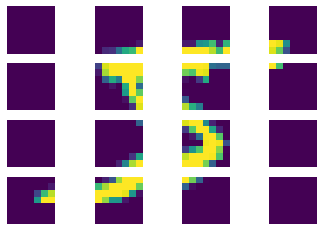

In [ ]:
fig = plt.figure()
plt.subplots_adjust(wspace=.2, hspace=.2)
for i, img in enumerate(images):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('off')
    ax.imshow(img)
plt.show()

In [ ]:
x_train[:,1:16,:].shape

(60000, 15, 49)

In [ ]:
model = keras.models.Sequential([
    keras.Input(shape=(None,49)),
    layers.GRU(49,return_sequences=True,activation='tanh'),
    layers.GRU(64,return_sequences=True,activation='tanh'),
    layers.Dropout(rate = 0.1),
    layers.Dense(49, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal())
])

In [ ]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
print(x_train[:,0:15,:].shape)
print(x_train[:,1:16,:].shape)

(60000, 15, 49)
(60000, 15, 49)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(x_train[:,0:15,:], x_train[:,1:16,:], epochs=100, callbacks=callback,batch_size=64,validation_data=[x_test[:,0:15,:],x_test[:,1:16,:]])

Epoch 1/100
938/938 [==============================] - 18s 16ms/step - loss: 0.0556 - val_loss: 0.0431
Epoch 2/100
938/938 [==============================] - 16s 17ms/step - loss: 0.0421 - val_loss: 0.0384
Epoch 3/100
938/938 [==============================] - 15s 16ms/step - loss: 0.0389 - val_loss: 0.0364
Epoch 4/100
938/938 [==============================] - 14s 15ms/step - loss: 0.0373 - val_loss: 0.0354
Epoch 5/100
938/938 [==============================] - 14s 15ms/step - loss: 0.0363 - val_loss: 0.0343
Epoch 6/100
938/938 [==============================] - 14s 15ms/step - loss: 0.0356 - val_loss: 0.0337
Epoch 7/100
938/938 [==============================] - 15s 16ms/step - loss: 0.0350 - val_loss: 0.0333
Epoch 8/100
938/938 [==============================] - 14s 15ms/step - loss: 0.0346 - val_loss: 0.0329
Epoch 9/100
938/938 [==============================] - 14s 15ms/step - loss: 0.0342 - val_loss: 0.0327
Epoch 10/100
938/938 [==============================] - 14s 15ms/step - l

In [ ]:
y_pred = x_test[0,0:8,:].reshape(1,8,49)
patch = model.predict(y_pred)

1/1 [==============================] - 1s 794ms/step


In [ ]:
print(patch.shape)

(1, 8, 49)


In [ ]:
single_patch = patch[:,7,:].reshape(1,1,49)
single_patch.shape

(1, 1, 49)

In [ ]:
id=7
for i in range(7):
  op = model.predict(patch)
  patch = np.hstack((patch, op[:,id,:].reshape(1,1,49)))
  id+=1

1/1 [==============================] - 0s 14ms/step


In [ ]:
patch = patch[:,8:,:]
patch.shape

(1, 8, 49)

In [ ]:
images = np.concatenate((y_pred[0],patch[0])).reshape(1,16,49)
images = images[0].reshape(16,7,7)

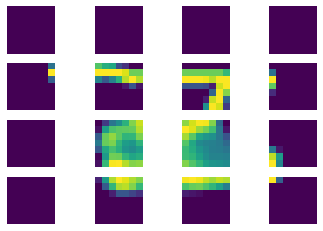

In [ ]:
fig = plt.figure()
plt.subplots_adjust(wspace=.2, hspace=.2)
for i,img in enumerate(images):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('off')
    ax.imshow(tf.reshape(img,[7,7]))
plt.show()

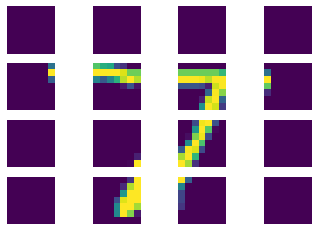

In [ ]:
test_img = x_test[0,:,:].reshape(16,7,7)
fig = plt.figure()
plt.subplots_adjust(wspace=.1, hspace=.2)
for i, img in enumerate(test_img):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('off')
    ax.imshow(tf.reshape(img,[7,7]))
plt.show()

In [ ]:
rows = tf.split(images,4,axis=0)
rows = [tf.concat(tf.unstack(x),axis=1) for x in rows] 
reconstructed = tf.concat(rows,axis=0)

In [ ]:
xtest_images=[]
for i in range(0,10):
  ytest_ind = np.where(y_test == i)
  xtest_images.append(x_test[ytest_ind[0][0:10]])

In [ ]:
def generate_image(img):
  y_pred = img[0:8,:].reshape(1,8,49)
  l = model.predict(y_pred)
  patch = l[:,7,:].reshape(1,1,49)
  patch = l
  m=7
  for i in range(7):
    l = model.predict(patch)
    patch = np.hstack((patch, l[:,m,:].reshape(1,1,49)))
    m=m+1
  patch = patch[:,8:,:]
  images = np.concatenate((y_pred[0],patch[0])).reshape(1,16,49)
  images = images[0].reshape(16,7,7)
  rows = tf.split(images,28//7,axis=0)
  rows = [tf.concat(tf.unstack(x),axis=1) for x in rows] 
  reconstructed = tf.concat(rows,axis=0)
  return reconstructed

In [ ]:
generated_grid = []
for i in range(0,10):
  for j in range(0,10):
    generated_grid.append(generate_image(xtest_images[i][j]))

1/1 [==============================] - 0s 15ms/step


In [ ]:
original_grid = []
for i in range(0,10):
  for j in range(0,10):
    img = xtest_images[i][j].reshape(16,7,7)
    rows = tf.split(img,4,axis=0)
    rows = [tf.concat(tf.unstack(x),axis=1) for x in rows] 
    original_grid.append(tf.concat(rows,axis=0))

In [ ]:
print(generated_grid[0].shape)
print(original_grid[0].shape)

(28, 28)
(28, 28)


In [ ]:
print(len(generated_grid))
print(len(original_grid))

100
100


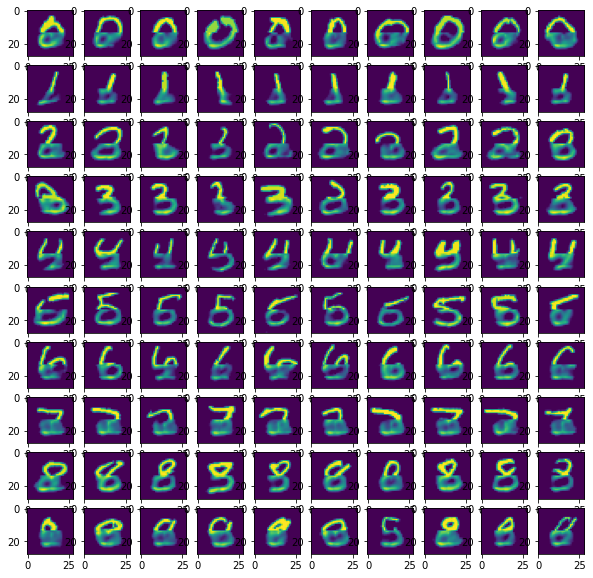

In [ ]:
fig, ax = plt.subplots(10,10,figsize=(10,10))
k=0
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(generated_grid[k])
        k+=1
plt.show()

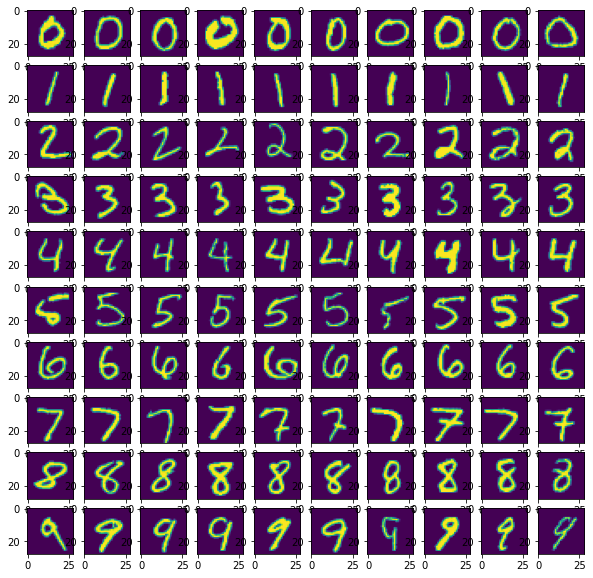

In [ ]:
fig, ax = plt.subplots(10,10,figsize=(10,10))
k=0
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(original_grid[k])
        k+=1
plt.show()

P2: Variational Autoencoders on Poor Sevens 

In [ ]:
# Reference: 
# https://www.tensorflow.org/tutorials/generative/cvae
# https://keras.io/examples/generative/vae/
# https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example

In [ ]:
train_path = '/content/drive/MyDrive/DLS_DATA/assign_5/hw5_tr7.pkl'
test_path = '/content/drive/MyDrive/DLS_DATA/assign_5/hw5_te7.pkl'

In [ ]:
with open(train_path, 'rb') as f:
    x_train = pickle.load(f)

In [ ]:
with open(test_path, 'rb') as f:
    x_test = pickle.load(f)

In [ ]:
print("Training Data Shape:",x_train.shape)
print("Testing Data Shape:",x_test.shape)

Training Data Shape: (6265, 28, 28)
Testing Data Shape: (1028, 28, 28)


In [ ]:
x_train = x_train
x_test = x_test

In [ ]:
train_size = 6265
batch_size = 32
test_size = 1028

In [ ]:
class parameterize(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(1024, activation="gelu")(x),
x = layers.Dense(1024, activation="gelu")(x[0]),
x = layers.Dense(1024, activation="gelu")(x[0]),
x = layers.Dense(1024, activation="gelu")(x[0]),
z_mean = layers.Dense(latent_dim, name="z_mean")(x[0])
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x[0])
z = parameterize()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_22 (Flatten)           (None, 784)          0           ['input_34[0][0]']               
                                                                                                  
 dense_151 (Dense)              (None, 1024)         803840      ['flatten_22[0][0]']             
                                                                                                  
 dense_152 (Dense)              (None, 1024)         1049600     ['dense_151[0][0]']              
                                                                                            

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(1024, activation="gelu")(latent_inputs),
x = layers.Dense(1024, activation="gelu")(x[0]),
x = layers.Dense(1024, activation="gelu")(x[0]),
x = layers.Dense(1024, activation="gelu")(x[0]),
decoder_outputs = layers.Dense(784, activation="sigmoid")(x[0])
outputs = keras.layers.Reshape(target_shape=(28,28,1),input_shape=(784,))(decoder_outputs)
decoder = keras.Model(latent_inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_155 (Dense)           (None, 1024)              5120      
                                                                 
 dense_156 (Dense)           (None, 1024)              1049600   
                                                                 
 dense_157 (Dense)           (None, 1024)              1049600   
                                                                 
 dense_158 (Dense)           (None, 1024)              1049600   
                                                                 
 dense_159 (Dense)           (None, 784)               803600    
                                                                 
 reshape_9 (Reshape)         (None, 28, 28, 1)         0   

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, encoder,decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")
        self.val_reconstruction_loss_tracker = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.val_kl_loss_tracker = keras.metrics.Mean(name="val_kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_kl_loss_tracker
        ]
    
    def compute_loss(self, x):
        mean,logvar,z = self.encoder(x)
        x_logit = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x, x_logit), axis=(1, 2)
                )
            )
        kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        return reconstruction_loss,kl_loss,total_loss
      
    def test_step(self,x):
        reconstruction_loss,kl_loss,loss = self.compute_loss(x)
        self.val_kl_loss_tracker.update_state(kl_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.val_total_loss_tracker.update_state(loss)

        return {
              "val_loss": self.total_loss_tracker.result(),
              "val_reconstruction_loss": self.reconstruction_loss_tracker.result(),
              "val_kl_loss": self.kl_loss_tracker.result(),
          }

    def train_step(self,x):
        with tf.GradientTape() as tape:
            reconstruction_loss,kl_loss,loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.total_loss_tracker.update_state(loss)

        return {
              "loss": self.total_loss_tracker.result(),
              "reconstruction_loss": self.reconstruction_loss_tracker.result(),
              "kl_loss": self.kl_loss_tracker.result(),
          }

In [ ]:
epochs = 10
latent_dim = 4

In [ ]:
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")

In [ ]:
vae = VAE(encoder,decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(
    mnist_digits,
    batch_size=32,
    epochs=epochs
)

Epoch 1/10
228/228 [==============================] - 30s 123ms/step - loss: 240.1464 - reconstruction_loss: 185.5958 - kl_loss: 5.0578
Epoch 2/10
228/228 [==============================] - 26s 116ms/step - loss: 148.2927 - reconstruction_loss: 140.7891 - kl_loss: 4.7733
Epoch 3/10
228/228 [==============================] - 27s 119ms/step - loss: 136.5457 - reconstruction_loss: 126.4817 - kl_loss: 6.3112
Epoch 4/10
228/228 [==============================] - 27s 118ms/step - loss: 127.5612 - reconstruction_loss: 118.9410 - kl_loss: 6.9804
Epoch 5/10
228/228 [==============================] - 27s 117ms/step - loss: 122.3450 - reconstruction_loss: 115.9191 - kl_loss: 7.1916
Epoch 6/10
228/228 [==============================] - 30s 132ms/step - loss: 121.5907 - reconstruction_loss: 113.9596 - kl_loss: 7.3140
Epoch 7/10
228/228 [==============================] - 27s 119ms/step - loss: 120.4253 - reconstruction_loss: 112.6810 - kl_loss: 7.3843
Epoch 8/10
228/228 [============================

In [ ]:
n = 10 # Number of images to reconstruct
K = 4 # Latent Vector Dimension

In [ ]:
z_rand = tf.constant(np.random.normal(0,1,size=(n,K)),dtype=tf.float32)

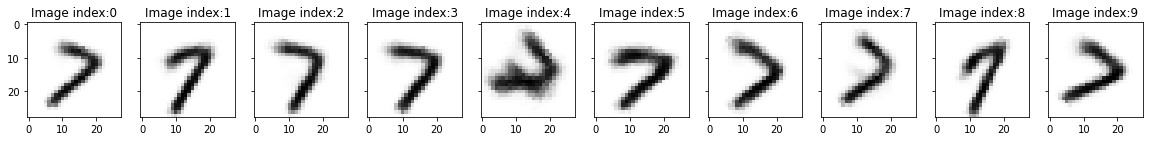

In [ ]:
x_rand_recon = vae.decoder(z_rand)
x_rand_recon = tf.reshape(x_rand_recon,shape=(-1,28,28)).numpy()
fig, axes = plt.subplots(1,n, figsize=(20,20),sharex=True, sharey=True,subplot_kw=dict(aspect='equal'))

for idx in range(0,n):
    ax = axes[idx]
    img = x_rand_recon[idx,:,:]
    ax.imshow(img, cmap='gray_r')
    ax.set_title("Image index:"+str(idx))

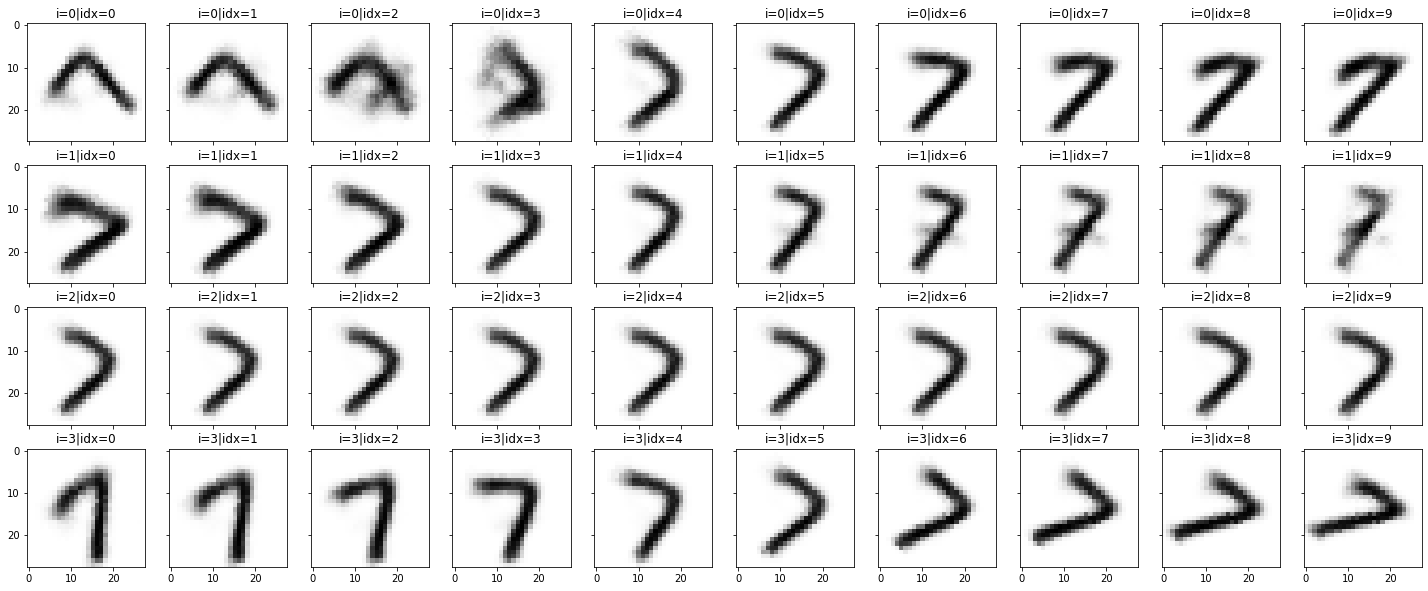

In [ ]:
val_rand = [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5]
x_rand_recon_overall = np.zeros((K,n,28,28))
s = np.array([np.random.normal(0, 1, 3)]*n).reshape(n,K-1)
for i in range(0,K):
  z_rand = np.zeros((n,K))
  for j in range(0,K):
    if(j==i):
      z_rand[:,i]= val_rand
    else:
      z_rand[:,j]= s[:,j-1]
  
  x_rand_recon = vae.decoder(z_rand)
  x_rand_recon_overall[i,:,:,:] = tf.reshape(x_rand_recon,shape=(-1,28,28)).numpy()
  
fig, axes = plt.subplots(K,n, 
                        figsize=(25,10),
                        sharex=True, sharey=True)
for i in range(0,K):
  for idx in range(0,n):
    ax = axes[i,idx]
    # plot image on subplot
    img = x_rand_recon_overall[i,idx,:,:]
    ax.imshow(img, cmap='gray_r')
    ax.set_title("i="+str(i)+"|idx="+str(idx))

In [ ]:
# Reasoning:
# The first dimension does not show similar looking seven's and shows a lot of changes
# The second dimension does some changes in the size of the sevens and it is not gradual.
# The third dimension shows similar looking images of seven and does not show any difference. 
# The fourth dimension shows similar looking images of seven and it rotates the seven gradually.
# Hence i think the fourth dimension corresponds to the effect added by professor.

P3: Conditional GAN

In [ ]:
# Reference:
# https://keras.io/examples/generative/conditional_gan/
# https://towardsdatascience.com/cgan-conditional-generative-adversarial-network-how-to-gain-control-over-gan-outputs-b30620bd0cc8#:~:text=Conditional%20GAN%20(cGAN)%20allows%20us,learn%20the%20difference%20between%20them.

In [3]:
batch_size = 100
num_classes = 10
latent_dim = 100
total_size = 784

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

all_digits = (all_digits.astype("float32") - 127.5) / 127.5
all_digits = np.reshape(all_digits, (-1, total_size))
all_labels = keras.utils.to_categorical(all_labels, num_classes)
# all_labels = tf.where(tf.equal(all_labels, 0), -1, all_labels)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

11490434/11490434 [==============================] - 1s 0us/step
Shape of training images: (70000, 784)
Shape of training labels: (70000, 10)


In [6]:
gen_input = latent_dim + num_classes
dis_input = total_size + num_classes
print("Generator Input Size:",gen_input)
print("Discriminator Input Size:",dis_input)

Generator Input Size: 110
Discriminator Input Size: 794


In [7]:
he_initializer = tf.keras.initializers.HeNormal()

In [8]:
# Create the discriminator.
discriminator = keras.Sequential(
    [   
        keras.layers.InputLayer((dis_input,)),
        layers.Dense(400,kernel_initializer = he_initializer),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(200,kernel_initializer = he_initializer),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.1),
        layers.Dense(100,kernel_initializer = he_initializer),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.1),
        layers.Dense(1,kernel_initializer = he_initializer)
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((gen_input,)),
        layers.Dense(200,kernel_initializer = he_initializer),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.5),
        layers.Dense(400,kernel_initializer = he_initializer),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.5),
        layers.Dense(784,kernel_initializer = he_initializer,activation='tanh')
    ],
    name="generator",
)

In [9]:
class C_GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(C_GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.real_acc_tracker = tf.keras.metrics.BinaryAccuracy(name="real_acc")
        self.fake_acc_tracker = tf.keras.metrics.BinaryAccuracy(name="fake_acc")
    
    def create_labels(self):
        c_labels = []
        for i in range(100):
            if(i%10==0):
              labels = [0,0,0,0,0,0,0,0,0,0]
              labels[i//10] = 1
            c_labels.append(labels)
        c_labels = np.array(c_labels)
        return c_labels

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker,self.real_acc_tracker,self.fake_acc_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(C_GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    def train_step(self, data):
        real_images, one_hot_labels = data

        one_hot_labels = tf.cast(one_hot_labels, tf.float32)

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        generated_images = self.generator(random_vector_labels)
        
        fake_image_and_labels = tf.concat([generated_images, one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, one_hot_labels], -1)
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        self.fake_acc_tracker.update_state(labels[:batch_size,:],predictions[:batch_size,:])
        self.real_acc_tracker.update_state(labels[batch_size:,:],predictions[batch_size:,:])

        c_labels = self.create_labels()

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, c_labels], axis=1)

        misleading_labels = tf.zeros((batch_size, 1))

        

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, c_labels], -1)
            predictions1 = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions1)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "real_acc": self.real_acc_tracker.result(),
            "fake_acc": self.fake_acc_tracker.result()
        }

In [ ]:
cond_gan = C_GAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

history = cond_gan.fit(dataset, epochs=100,batch_size=128)

Epoch 1/100
700/700 [==============================] - 15s 20ms/step - g_loss: 6.7157 - d_loss: 0.0443 - real_acc: 0.9997 - fake_acc: 0.9912
Epoch 2/100
700/700 [==============================] - 14s 20ms/step - g_loss: 12.3202 - d_loss: 0.0146 - real_acc: 0.9956 - fake_acc: 0.9880
Epoch 3/100
700/700 [==============================] - 14s 20ms/step - g_loss: 11.7925 - d_loss: 0.0968 - real_acc: 0.9703 - fake_acc: 0.9396
Epoch 4/100
700/700 [==============================] - 15s 21ms/step - g_loss: 6.3605 - d_loss: 0.1722 - real_acc: 0.9467 - fake_acc: 0.8994
Epoch 5/100
700/700 [==============================] - 15s 21ms/step - g_loss: 4.8026 - d_loss: 0.2024 - real_acc: 0.9361 - fake_acc: 0.8755
Epoch 6/100
700/700 [==============================] - 14s 20ms/step - g_loss: 3.9088 - d_loss: 0.2828 - real_acc: 0.9059 - fake_acc: 0.8179
Epoch 7/100
700/700 [==============================] - 14s 20ms/step - g_loss: 3.5956 - d_loss: 0.2872 - real_acc: 0.9097 - fake_acc: 0.8185
Epoch 8/100

Text(0.5, 1.0, 'Discriminator Real and Fake Accuracies')

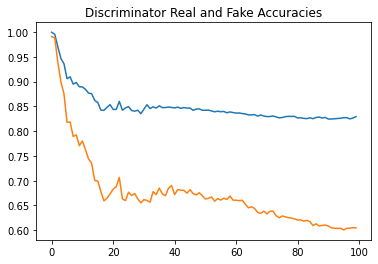

In [ ]:
# print(history.history)
plt.plot(history.history['real_acc'],label='Real Images Accuracy')
plt.plot(history.history['fake_acc'],label='Fake Images Accuracy')
plt.legend(loc="upper right")
plt.title("Real and Fake Accuracies")

4/4 [==============================] - 0s 3ms/step


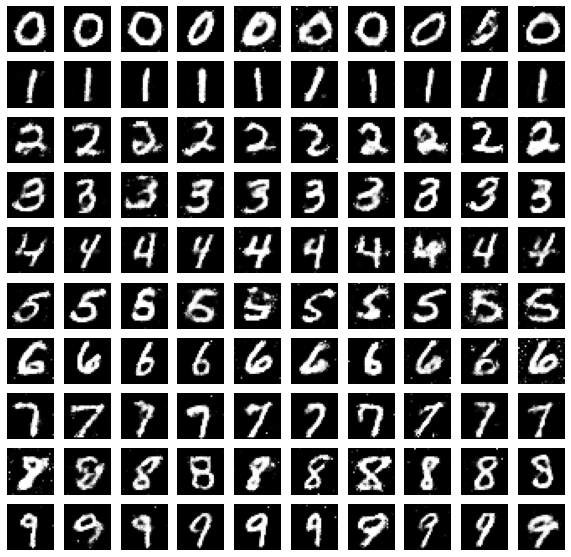

In [ ]:
noise = np.random.normal(0,1,(100, latent_dim))

labels=[]
for x in np.eye(10):
  for i in range(10):
    labels.append(x.tolist())
labels = np.array(labels)

image = cond_gan.generator.predict(np.concatenate([noise,labels],axis=1))
image = 0.5 * image + 0.5
fig, ax = plt.subplots(10,10, figsize = (10,10))
cnt = 0
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(image[cnt,:].reshape((28,28)),cmap = 'gray')
        ax[i,j].axis('off')
        cnt+=1
plt.show()

P4: Missing Value Imputation Using Conditional GAN

In [50]:
# References: 
# https://www.tensorflow.org/guide/keras/custom_layers_and_models
# https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
# 

In [3]:
(xtrain, y_train), (xtest, y_test) = tf.keras.datasets.mnist.load_data()
xtrain_flatten = []
for i  in range(xtrain.shape[0]):
    xtrain_flatten.append(xtrain[i].flatten())
xtrain = np.array(xtrain_flatten)
xtest_flatten = []
for j in range(xtest.shape[0]):
    xtest_flatten.append(xtest[j].flatten())
xtest = np.array(xtest_flatten)
xtrain = (xtrain.astype("float32")- 127.5) / 127.5
xtest = (xtest.astype("float32")- 127.5) / 127.5

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
print(xtrain.shape)
print(xtest.shape)

(60000, 784)
(10000, 784)


In [29]:
n_epochs = 75 # max number of epochs
batch_size = 100 # training batch size 
learning_rate = 0.0002 # learn rate
patience = 15  # epochs after which training should stop if no improvement
dim = 100
patches = 100
noise_channel = keras.Input(shape=(dim,))
patch_channel = keras.Input(shape=(patches,))

In [30]:
all_data = tf.concat([xtrain, xtest], axis=0)
all_labels = tf.concat([y_train, y_test], axis=0)

In [31]:
dataset = tf.data.Dataset.from_tensor_slices((all_data, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [32]:
gen_input = 100 + 100
dis_input = 784 

In [33]:
discriminator = keras.Sequential(
    [   
        keras.layers.InputLayer((dis_input,)),
        layers.Dense(400,kernel_initializer = tf.keras.initializers.HeNormal(), activation = tf.nn.leaky_relu),
        tf.keras.layers.Dropout(0.2),
        layers.Dense(200,kernel_initializer = tf.keras.initializers.HeNormal(), activation = tf.nn.leaky_relu),
        tf.keras.layers.Dropout(0.2),
        layers.Dense(100,kernel_initializer = tf.keras.initializers.HeNormal(), activation = tf.nn.leaky_relu),
        tf.keras.layers.Dropout(0.1),
        layers.Dense(1,kernel_initializer = tf.keras.initializers.GlorotNormal(),activation = tf.nn.sigmoid)
    ],
    name="discriminator",
)


In [34]:
generator = keras.Sequential(
    [
        keras.layers.InputLayer((gen_input,)),
        layers.Dense(500,kernel_initializer = tf.keras.initializers.HeNormal()),
        layers.BatchNormalization(momentum=0.5),
        layers.Dense(1024,kernel_initializer = tf.keras.initializers.HeNormal()),
        layers.BatchNormalization(momentum=0.5),
        layers.Dense(784,kernel_initializer = tf.keras.initializers.HeNormal(),activation='tanh')
    ],
    name="generator",
)
  

In [35]:
class C_Gan(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(C_Gan, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.real_acc_tracker = tf.keras.metrics.BinaryAccuracy(name="real_acc")
        self.fake_acc_tracker = tf.keras.metrics.BinaryAccuracy(name="fake_acc")
    
    def middle_patch(self,data):
        real_images = data
        image_data = tf.reshape(real_images,shape=(-1,28,28))
        middle_images = image_data[:,10:20,10:20]
        new_images = tf.reshape(middle_images,shape=(-1,100))

        return new_images

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker,self.real_acc_tracker,self.fake_acc_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(C_Gan, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    def train_step(self, data):
        real_images, one_hot_labels = data
        new_images = self.middle_patch(real_images)

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, new_images], axis=1)

        generated_images = self.generator(random_vector_labels)
        
        fake_image_and_labels = generated_images
        real_image_and_labels = real_images
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        self.fake_acc_tracker.update_state(labels[:batch_size,:],predictions[:batch_size,:])
        self.real_acc_tracker.update_state(labels[batch_size:,:],predictions[batch_size:,:])

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, new_images], axis=1)
        
        misleading_labels = tf.zeros((batch_size, 1))
        misleading_labels = tf.cast(misleading_labels,dtype=tf.float32)

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            new_generated_images = self.middle_patch(fake_images)
            predictions = self.discriminator(fake_images) 
            new_images = tf.cast(new_images,dtype=tf.float32)
            new_generated_images = tf.cast(new_generated_images,dtype=tf.float32)
            
            predictions = tf.cast(predictions,dtype=tf.float32)
            loss = self.loss_fn(misleading_labels, predictions)
            temp = 10*tf.math.reduce_mean((new_generated_images - new_images)**2)
            g_loss = loss+temp
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "real_acc": self.real_acc_tracker.result(),
            "fake_acc": self.fake_acc_tracker.result()
        }

In [36]:
cond_gan = C_Gan(
    discriminator=discriminator, generator=generator, latent_dim=dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = cond_gan.fit(dataset, epochs=n_epochs,batch_size=batch_size)

Epoch 1/75
700/700 [==============================] - 5s 6ms/step - g_loss: 3.8790 - d_loss: 0.5128 - real_acc: 1.0000 - fake_acc: 0.9905
Epoch 2/75
700/700 [==============================] - 4s 6ms/step - g_loss: 1.3944 - d_loss: 0.5060 - real_acc: 0.9966 - fake_acc: 0.9779
Epoch 3/75
700/700 [==============================] - 4s 6ms/step - g_loss: 1.3607 - d_loss: 0.5159 - real_acc: 0.9897 - fake_acc: 0.9582
Epoch 4/75
700/700 [==============================] - 4s 6ms/step - g_loss: 1.3501 - d_loss: 0.5234 - real_acc: 0.9761 - fake_acc: 0.9356
Epoch 5/75
700/700 [==============================] - 4s 6ms/step - g_loss: 1.3335 - d_loss: 0.5360 - real_acc: 0.9512 - fake_acc: 0.8842
Epoch 6/75
700/700 [==============================] - 4s 6ms/step - g_loss: 1.2368 - d_loss: 0.5846 - real_acc: 0.9261 - fake_acc: 0.5851
Epoch 7/75
700/700 [==============================] - 4s 6ms/step - g_loss: 1.2138 - d_loss: 0.5914 - real_acc: 0.9121 - fake_acc: 0.6076
Epoch 8/75
700/700 [==============

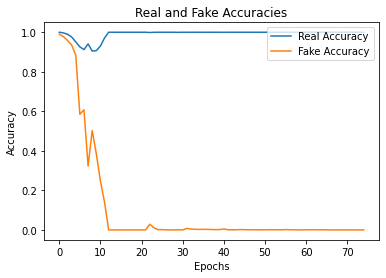

In [37]:
plt.plot(history.history['real_acc'], label='Real Accuracy')
plt.plot(history.history['fake_acc'], label='Fake Accuracy')
plt.legend(loc="upper right")
plt.title("Real and Fake Accuracies")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [38]:
result = []
for i in range(10):
    result.append(np.array(np.where(y_test == i)[0][:10]))
final_array = np.concatenate(result, axis=0)

Mnist Digit Images


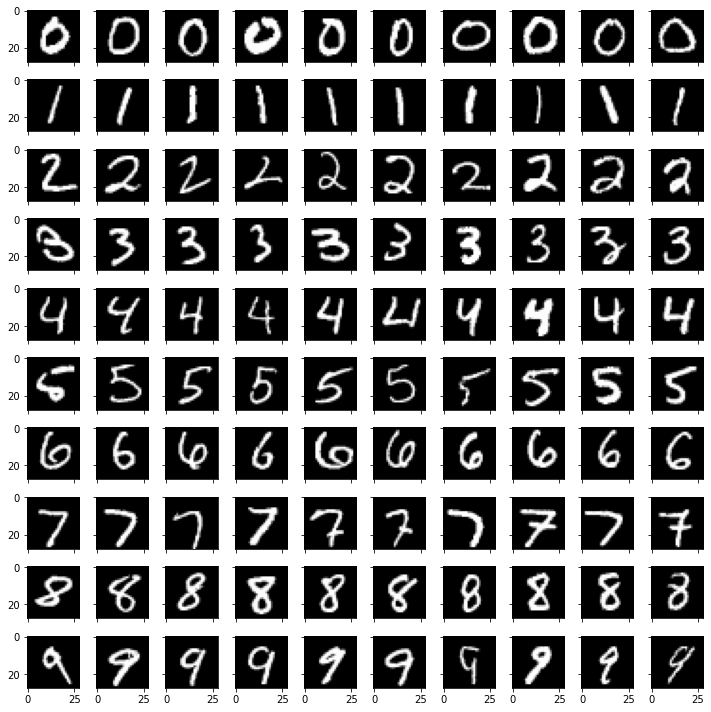

In [39]:
print("Mnist Digit Images")
fig, axes = plt.subplots(10,10, figsize=(10,10), sharey=True, sharex=True)

xtest_show = xtest[final_array]
cnt = 0
for i in range(10):
  for j in range(10):
    ax = axes[i,j]
    ax.imshow(xtest_show[cnt].reshape(28,28), cmap='gray')
    cnt+= 1
fig.tight_layout() 
plt.show()

Generated Images
4/4 [==============================] - 0s 2ms/step


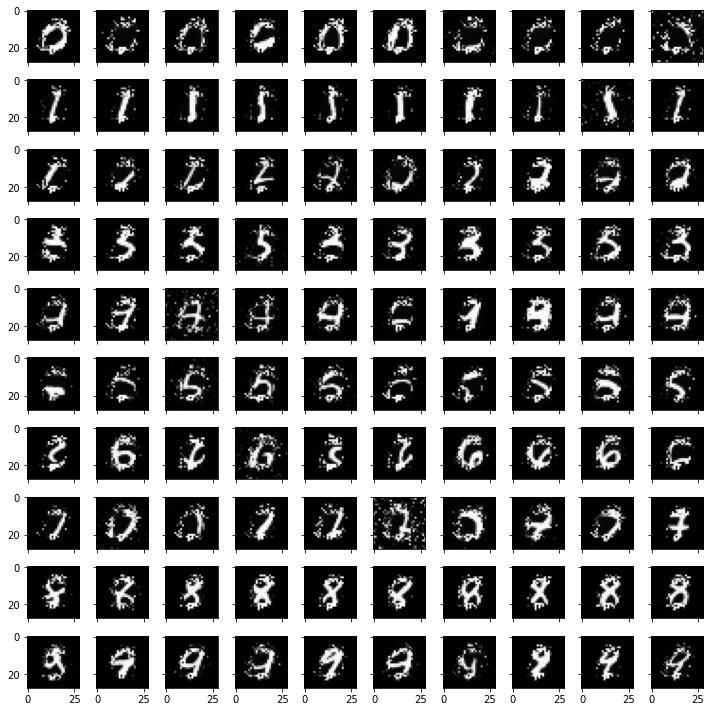

In [40]:
print("Generated Images")
noise = np.random.normal(0,1,(10*10, dim))

mean_patch = tf.reshape(xtest_show,shape=[-1,28,28])[:,10:20,10:20]
mean_patch = tf.reshape(mean_patch,[mean_patch.shape[0], -1])

gen_image = cond_gan.generator.predict(tf.concat([noise, mean_patch], axis=1))

gen_image = tf.reshape(gen_image,shape=[-1,28,28])

# Convert back to [0,1] range
gen_image = (0.5 * gen_image) + 0.5

fig, axes = plt.subplots(10,10, figsize=(10,10), sharey=True, sharex=True)

cnt = 0
for i in range(10):
  for j in range(10):
    ax = axes[i,j]
    ax.imshow(gen_image[cnt], cmap='gray')
    cnt+= 1
fig.tight_layout() 
plt.show()

In [ ]:
# The images generated looks similar to the 